# PMEL MAPCO2 Data Importer

Compile and plot all data available from one MAPCO2 mooring.

#### Standard Libraries

In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 200)

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.offline as ply

#import cufflinks as cf
#cf.go_offline()



#### Custom Libraries

In [2]:
package_path = 'C:\\Users\\dietrich\\code\\'
sys.path.insert(0, package_path)

In [3]:
from pyMAPCO2 import load, final, algebra, config
from pyMAPCO2.algebra import linear_fit
from pyMAPCO2 import plot, plot_ply, plot_plt

### I. Data File Locations

In [4]:
#final_dir = '.\\boboa'
f_mbl = ('C:\\Users\\dietrich\\code\\pyMAPCO2\\notebooks\\outputs\\' + 
         'WHOTS dp01-09 2007-2017_mbl_data_2017-04-24 22_04_34.183115.csv')

In [5]:
deployment_name = 'WHOTS 2007-2017 | Deployments 01-09'
deployment_name_short = 'WHOTS_dp01-07_2007-2014'

In [6]:
show_ply_timeseries = True
show_ply_multiyear = True

#### list of files to import

In [7]:
p = Path('./whots')
df_source = [f for f in list(p.glob('**/*.csv')) if 'QFLog' not in str(f)]
df_source

[WindowsPath('whots/WHOTS_158W_23N_dp01_Jun2007_Jun2008.csv'),
 WindowsPath('whots/WHOTS_158W_23N_dp02_Jun2008_Feb2009.csv'),
 WindowsPath('whots/WHOTS_158W_23N_dp03_Jul2009_Aug2010.csv'),
 WindowsPath('whots/WHOTS_158W_23N_dp04_Aug2010_Jul2011.csv'),
 WindowsPath('whots/WHOTS_158W_23N_dp06_Jun2012_Nov2012.csv'),
 WindowsPath('whots/WHOTS_158W_23N_dp07_Jul2013_Jul2014.csv')]

### II. Import Data & Format

#### 1. Import and use header row for column names

In [8]:
df = final.read_files(df_source)

Loading:  whots\WHOTS_158W_23N_dp01_Jun2007_Jun2008.csv
Loading:  whots\WHOTS_158W_23N_dp02_Jun2008_Feb2009.csv
Loading:  whots\WHOTS_158W_23N_dp03_Jul2009_Aug2010.csv
Loading:  whots\WHOTS_158W_23N_dp04_Aug2010_Jul2011.csv
Loading:  whots\WHOTS_158W_23N_dp06_Jun2012_Nov2012.csv
Loading:  whots\WHOTS_158W_23N_dp07_Jul2013_Jul2014.csv


In [9]:
df.head()

,Mooring,Latitude,Longitude,Date,Time,xCO2_SW_wet,xCO2_SW_QF,H2O_SW,xCO2_Air_wet,xCO2_Air_QF,H2O_AIR,Licor_Atm_Pressure,Licor_Temp,Percent_O2,SST,SSS,xCO2_SW_dry,xCO2_Air_dry,fCO2_SW_sat,fCO2_Air_sat,dfCO2,pCO2_SW_sat,pCO2_Air_sat,dpCO2,pH,pH_QF
0,WHOTS_158W_23N,22.67,-157.97,06/26/2007,02:05,375.7,2.0,6.19,386.9,2.0,6.62,1023,26.1,99.81,25.3254,35.016,378.1,389.5,368.7,379.9,-11.2,NaN,NaN,NaN,NaN,NaN
1,WHOTS_158W_23N,22.67,-157.97,06/26/2007,02:35,375.2,2.0,5.98,387.1,2.0,6.06,1022.5,26.4,100.05,25.328,35.017,377.4,389.5,367.9,379.7,-11.8,NaN,NaN,NaN,NaN,NaN
2,WHOTS_158W_23N,22.67,-157.97,06/26/2007,03:05,375,2.0,6.04,387.1,2.0,6.46,1022.9,26.6,100.19,25.3178,35.017,377.3,389.7,368,380,-12,NaN,NaN,NaN,NaN,NaN
3,WHOTS_158W_23N,22.67,-157.97,06/26/2007,03:35,374.4,2.0,6.43,386.9,2.0,6.17,1023,26.8,100.19,25.3075,35.017,376.9,389.3,367.6,379.6,-12.1,NaN,NaN,NaN,NaN,NaN
4,WHOTS_158W_23N,22.67,-157.97,06/26/2007,04:05,375.6,2.0,6.46,388.2,2.0,6.55,1022.6,26.8,100.29,25.2985,35.018,378.1,390.8,368.6,381,-12.4,NaN,NaN,NaN,NaN,NaN


In [10]:
df = final.refactor(df)

In [11]:
df.head()

,Mooring,Latitude,Longitude,Date,Time,xCO2_SW_wet,xCO2_SW_QF,H2O_SW,xCO2_Air_wet,xCO2_Air_QF,H2O_AIR,Licor_Atm_Pressure,Licor_Temp,Percent_O2,SST,SSS,xCO2_SW_dry,xCO2_Air_dry,fCO2_SW_sat,fCO2_Air_sat,dfCO2,pCO2_SW_sat,pCO2_Air_sat,dpCO2,pH,pH_QF,datetime64_ns,year,dayofyear,time,day,xCO2_Air_dry_flagged_3,xCO2_SW_dry_flagged_3,pH_flagged_3
0,WHOTS_158W_23N,22.67,-157.97,06/26/2007,02:05,375.7,2.0,6.19,386.9,2.0,6.62,1023.0,26.1,99.81,25.3254,35.016,378.1,389.5,368.7,379.9,-11.2,NaN,NaN,NaN,NaN,NaN,2007-06-26 02:05:00,2007,177,02:05:00,177.086806,NaN,NaN,NaN
1,WHOTS_158W_23N,22.67,-157.97,06/26/2007,02:35,375.2,2.0,5.98,387.1,2.0,6.06,1022.5,26.4,100.05,25.3280,35.017,377.4,389.5,367.9,379.7,-11.8,NaN,NaN,NaN,NaN,NaN,2007-06-26 02:35:00,2007,177,02:35:00,177.107639,NaN,NaN,NaN
2,WHOTS_158W_23N,22.67,-157.97,06/26/2007,03:05,375.0,2.0,6.04,387.1,2.0,6.46,1022.9,26.6,100.19,25.3178,35.017,377.3,389.7,368.0,380.0,-12.0,NaN,NaN,NaN,NaN,NaN,2007-06-26 03:05:00,2007,177,03:05:00,177.128472,NaN,NaN,NaN
3,WHOTS_158W_23N,22.67,-157.97,06/26/2007,03:35,374.4,2.0,6.43,386.9,2.0,6.17,1023.0,26.8,100.19,25.3075,35.017,376.9,389.3,367.6,379.6,-12.1,NaN,NaN,NaN,NaN,NaN,2007-06-26 03:35:00,2007,177,03:35:00,177.149306,NaN,NaN,NaN
4,WHOTS_158W_23N,22.67,-157.97,06/26/2007,04:05,375.6,2.0,6.46,388.2,2.0,6.55,1022.6,26.8,100.29,25.2985,35.018,378.1,390.8,368.6,381.0,-12.4,NaN,NaN,NaN,NaN,NaN,2007-06-26 04:05:00,2007,177,04:05:00,177.170139,NaN,NaN,NaN


In [12]:
df.tail()

,Mooring,Latitude,Longitude,Date,Time,xCO2_SW_wet,xCO2_SW_QF,H2O_SW,xCO2_Air_wet,xCO2_Air_QF,H2O_AIR,Licor_Atm_Pressure,Licor_Temp,Percent_O2,SST,SSS,xCO2_SW_dry,xCO2_Air_dry,fCO2_SW_sat,fCO2_Air_sat,dfCO2,pCO2_SW_sat,pCO2_Air_sat,dpCO2,pH,pH_QF,datetime64_ns,year,dayofyear,time,day,xCO2_Air_dry_flagged_3,xCO2_SW_dry_flagged_3,pH_flagged_3
14723,WHOTS_158W_23N,22.665,-157.969,07/20/2014,06:17,403.2,2.0,11.23,390.9,2.0,10.40,1015.7,26.5,99.37,26.147,35.232,407.8,395.0,394.2,381.8,12.4,395.4,383.0,12.4,NaN,NaN,2014-07-20 06:17:00,2014,201,06:17:00,201.261806,NaN,NaN,NaN
14724,WHOTS_158W_23N,22.665,-157.969,07/20/2014,09:17,402.2,2.0,11.36,391.5,2.0,10.62,1015.7,26.1,99.39,26.097,35.229,406.9,395.7,393.3,382.5,10.8,394.5,383.7,10.8,NaN,NaN,2014-07-20 09:17:00,2014,201,09:17:00,201.386806,NaN,NaN,NaN
14725,WHOTS_158W_23N,22.665,-157.969,07/20/2014,12:17,401.7,2.0,10.99,390.5,2.0,10.42,1013.1,26.1,99.41,26.046,35.213,406.2,394.6,391.6,380.5,11.2,392.9,381.7,11.2,NaN,NaN,2014-07-20 12:17:00,2014,201,12:17:00,201.511806,NaN,NaN,NaN
14726,WHOTS_158W_23N,22.665,-157.969,07/20/2014,15:17,402.2,2.0,10.57,392.0,2.0,10.12,1012.4,26.0,99.37,26.014,35.194,406.5,396.0,391.7,381.6,10.1,392.9,382.8,10.1,NaN,NaN,2014-07-20 15:17:00,2014,201,15:17:00,201.636806,NaN,NaN,NaN
14727,WHOTS_158W_23N,22.665,-157.969,07/20/2014,18:17,401.1,2.0,10.90,392.0,2.0,10.42,1015.4,25.7,99.41,25.956,35.163,405.5,396.1,392.0,382.9,9.1,393.2,384.1,9.1,NaN,NaN,2014-07-20 18:17:00,2014,201,18:17:00,201.761806,NaN,NaN,NaN


In [13]:
df.columns

Index(['Mooring', 'Latitude', 'Longitude', 'Date', 'Time', 'xCO2_SW_wet',
       'xCO2_SW_QF', 'H2O_SW', 'xCO2_Air_wet', 'xCO2_Air_QF', 'H2O_AIR',
       'Licor_Atm_Pressure', 'Licor_Temp', 'Percent_O2', 'SST', 'SSS',
       'xCO2_SW_dry', 'xCO2_Air_dry', 'fCO2_SW_sat', 'fCO2_Air_sat', 'dfCO2',
       'pCO2_SW_sat', 'pCO2_Air_sat', 'dpCO2', 'pH', 'pH_QF', 'datetime64_ns',
       'year', 'dayofyear', 'time', 'day', 'xCO2_Air_dry_flagged_3',
       'xCO2_SW_dry_flagged_3', 'pH_flagged_3'],
      dtype='object')

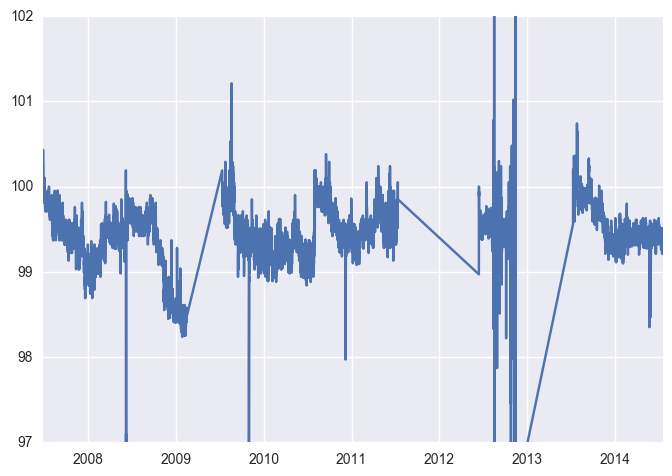

In [14]:
plt.plot(df.datetime64_ns, df.Percent_O2)
plt.ylim(97, 102)
plt.show()

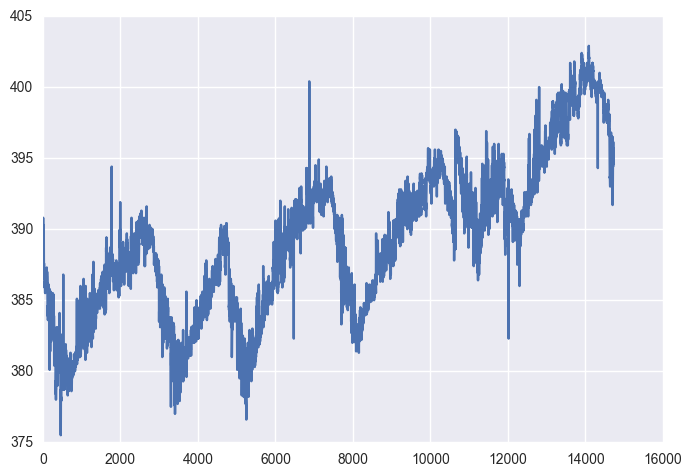

In [15]:
plt.plot(df.xCO2_Air_dry)
plt.show()

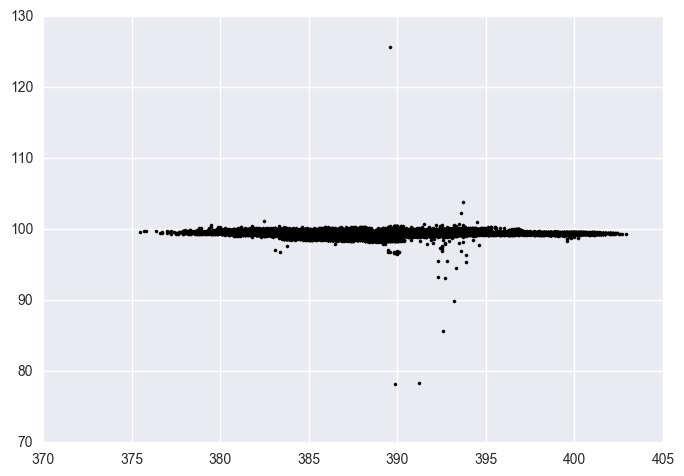

In [16]:
plt.scatter(df.xCO2_Air_dry, df.Percent_O2, marker='.', color='black')
plt.show()

### III. MBL import

In [17]:
df_mbl = load.mbl_site(f_mbl)

#### Filter Based on Deployment Time Range

In [18]:
df.datetime64_ns.min()

Timestamp('2007-06-26 02:05:00')

In [19]:
df.datetime64_ns.max()

Timestamp('2014-07-20 18:17:00')

In [20]:
df_mbl = df_mbl[(df_mbl.datetime64_ns >= df.datetime64_ns.min()) & 
              (df_mbl.datetime64_ns <= df.datetime64_ns.max())]

In [21]:
df_mbl.head()

,datetime_mbl,xCO2,xCO2_uncert,xCO2_low_uncert,xCO2_high_uncert,datetime64_ns
1368,2007-07-02 12:00:00.000000,384.3564,0.2584,384.0980,384.6148,2007-07-02 12:00:00.000000
1369,2007-07-10 02:29:49.487994,383.6707,0.2982,383.3725,383.9689,2007-07-10 02:29:49.487994
1370,2007-07-17 17:00:10.512006,382.9494,0.3388,382.6106,383.2882,2007-07-17 17:00:10.512006
1371,2007-07-25 07:30:00.000000,382.2207,0.3743,381.8464,382.5950,2007-07-25 07:30:00.000000
1372,2007-08-01 21:59:49.487994,381.5105,0.3986,381.1119,381.9091,2007-08-01 21:59:49.487994


In [22]:
df_mbl.tail()

,datetime_mbl,xCO2,xCO2_uncert,xCO2_low_uncert,xCO2_high_uncert,datetime64_ns
1702,2014-06-17 06:59:49.487994,400.7595,0.3145,400.4450,401.0740,2014-06-17 06:59:49.487994
1703,2014-06-24 21:30:10.512006,400.1444,0.3786,399.7658,400.5230,2014-06-24 21:30:10.512006
1704,2014-07-02 12:00:00.000000,399.5108,0.4444,399.0664,399.9552,2014-07-02 12:00:00.000000
1705,2014-07-10 02:29:49.487994,398.8770,0.5044,398.3726,399.3814,2014-07-10 02:29:49.487994
1706,2014-07-17 17:00:10.512006,398.2481,0.5493,397.6988,398.7974,2014-07-17 17:00:10.512006


### V. PCO2 vs SST Relationship

In [23]:
df_pco2_SST = df[['datetime64_ns', 'xCO2_SW_dry', 'SST']].copy()

In [24]:
df_pco2_SST.dropna(axis=0, how='any', inplace=True)

In [25]:
_x = df_pco2_SST.xCO2_SW_dry
_y = df_pco2_SST.SST
pco2_SST_linear_popt, pco2_SST_linear_pcov = curve_fit(algebra.linear_fit, _x, _y)
(pco2_SST_linear_popt, pco2_SST_linear_pcov)

(array([ 0.06508349,  0.04376914]),
 array([[  1.24009302e-07,  -4.76795222e-05],
        [ -4.76795222e-05,   1.83538838e-02]]))

In [26]:
df_pco2_SST['linear_fit'] = algebra.linear_fit(_x,
                                               pco2_SST_linear_popt[0],
                                               pco2_SST_linear_popt[1])

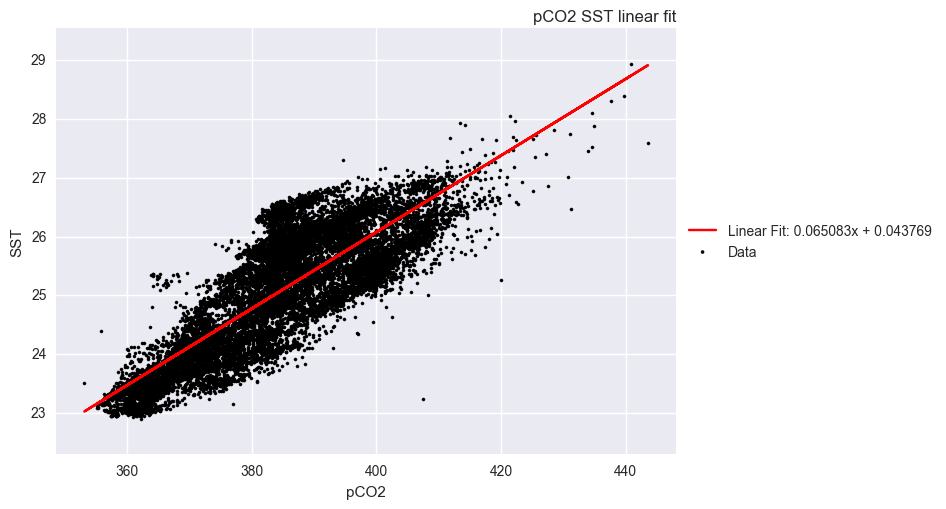

In [27]:
plt.scatter(_x, _y, label='Data', marker='.', color='black')
plt.plot(_x, df_pco2_SST.linear_fit,
         'r-',
         label='Linear Fit: {:3f}x + {:3f}'.format(pco2_SST_linear_popt[0],
                                                   pco2_SST_linear_popt[1]))
plt.title('pCO2 SST linear fit', loc='right')
plt.margins(0.05, 0.1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('pCO2')
plt.ylabel('SST')
plt.show()

### VI. Full Timeseries Plots

In [28]:
pd.to_datetime('2017/04/22')

Timestamp('2017-04-22 00:00:00')

In [29]:
data = plot_ply.default_data(df, df_mbl)

In [30]:
co2_lim = plot.lim_finder(data=df.xCO2_SW_dry, data_type='xco2_sw')
co2_lim

(317.79000000000002, 487.96000000000004)

In [31]:
sst_lim = plot.lim_finder(data=df.SST, data_type='sst')
sst_lim

(20.6127, 31.832900000000002)

In [32]:
ph_lim = config.k_limits['ph']
ph_lim

[6, 9]

In [33]:
sso2_lim = config.k_limits['o2_percent']
sso2_lim

[85, 100]

In [34]:
layout = plot_ply.default_layout(xco2_range=co2_lim,
                                 sst_range=sst_lim,
                                 ph_range=ph_lim,
                                 sso2_range=sso2_lim,
                                 title='Test!')

In [36]:
fig_timeseries = dict(data=data, layout=layout)
_f = deployment_name_short + '_mapco2_pco2_ph_sstc_timeseries.html'
ply.plot(fig_timeseries, output_type='file',
         auto_open=True, filename=_f,  show_link=False)

'file://C:\\Users\\dietrich\\data\\mapco2_data\\WHOTS_dp01-07_2007-2014_mapco2_pco2_ph_sstc_timeseries.html'

### VII. Multiyear Plot

In [37]:
df.head()

,Mooring,Latitude,Longitude,Date,Time,xCO2_SW_wet,xCO2_SW_QF,H2O_SW,xCO2_Air_wet,xCO2_Air_QF,H2O_AIR,Licor_Atm_Pressure,Licor_Temp,Percent_O2,SST,SSS,xCO2_SW_dry,xCO2_Air_dry,fCO2_SW_sat,fCO2_Air_sat,dfCO2,pCO2_SW_sat,pCO2_Air_sat,dpCO2,pH,pH_QF,datetime64_ns,year,dayofyear,time,day,xCO2_Air_dry_flagged_3,xCO2_SW_dry_flagged_3,pH_flagged_3
0,WHOTS_158W_23N,22.67,-157.97,06/26/2007,02:05,375.7,2.0,6.19,386.9,2.0,6.62,1023.0,26.1,99.81,25.3254,35.016,378.1,389.5,368.7,379.9,-11.2,NaN,NaN,NaN,NaN,NaN,2007-06-26 02:05:00,2007,177,02:05:00,177.086806,NaN,NaN,NaN
1,WHOTS_158W_23N,22.67,-157.97,06/26/2007,02:35,375.2,2.0,5.98,387.1,2.0,6.06,1022.5,26.4,100.05,25.3280,35.017,377.4,389.5,367.9,379.7,-11.8,NaN,NaN,NaN,NaN,NaN,2007-06-26 02:35:00,2007,177,02:35:00,177.107639,NaN,NaN,NaN
2,WHOTS_158W_23N,22.67,-157.97,06/26/2007,03:05,375.0,2.0,6.04,387.1,2.0,6.46,1022.9,26.6,100.19,25.3178,35.017,377.3,389.7,368.0,380.0,-12.0,NaN,NaN,NaN,NaN,NaN,2007-06-26 03:05:00,2007,177,03:05:00,177.128472,NaN,NaN,NaN
3,WHOTS_158W_23N,22.67,-157.97,06/26/2007,03:35,374.4,2.0,6.43,386.9,2.0,6.17,1023.0,26.8,100.19,25.3075,35.017,376.9,389.3,367.6,379.6,-12.1,NaN,NaN,NaN,NaN,NaN,2007-06-26 03:35:00,2007,177,03:35:00,177.149306,NaN,NaN,NaN
4,WHOTS_158W_23N,22.67,-157.97,06/26/2007,04:05,375.6,2.0,6.46,388.2,2.0,6.55,1022.6,26.8,100.29,25.2985,35.018,378.1,390.8,368.6,381.0,-12.4,NaN,NaN,NaN,NaN,NaN,2007-06-26 04:05:00,2007,177,04:05:00,177.170139,NaN,NaN,NaN


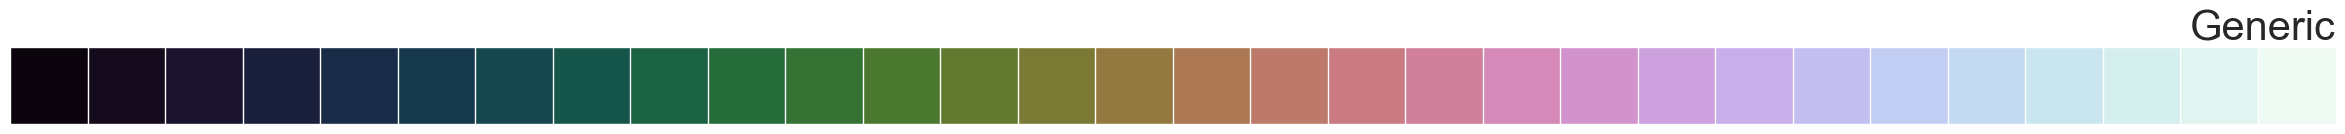

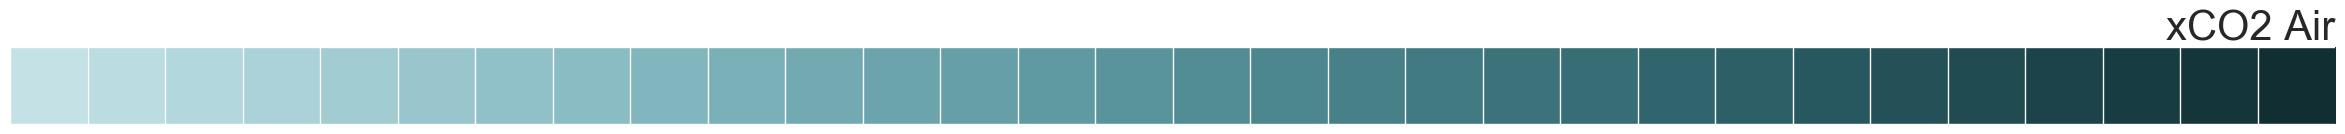

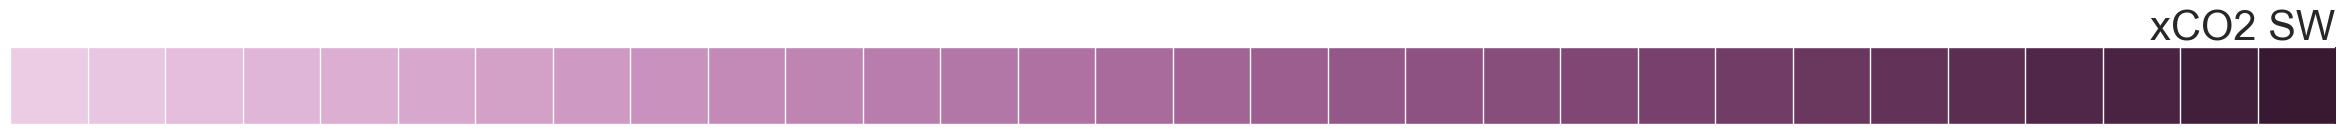

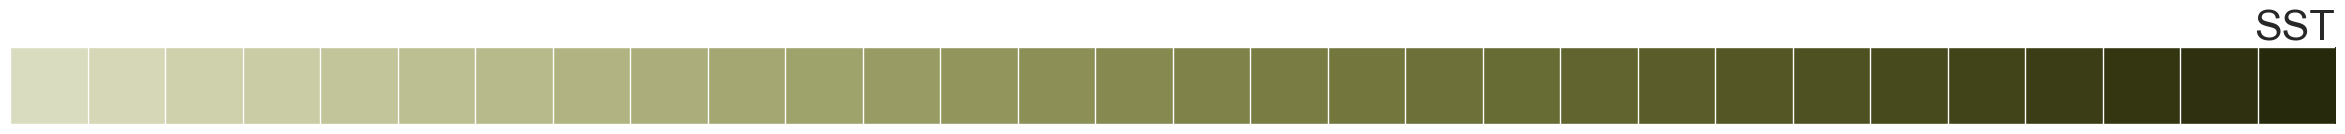

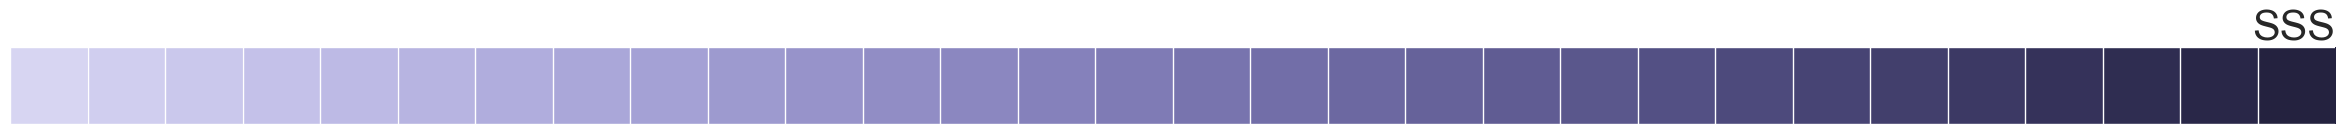

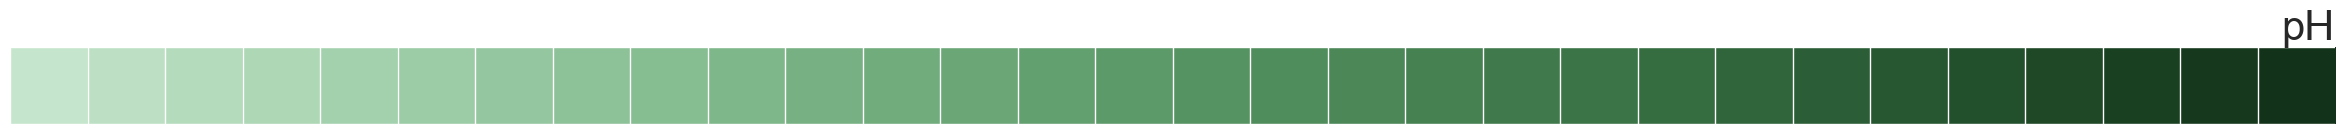

In [38]:
plot.demo_palletes()

In [39]:
plot.years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [40]:
pivots = plot.pivot(df)

In [41]:
day_my, xco2_air_my, xco2_sw_my, sst_my, sss_my, ph_my = pivots

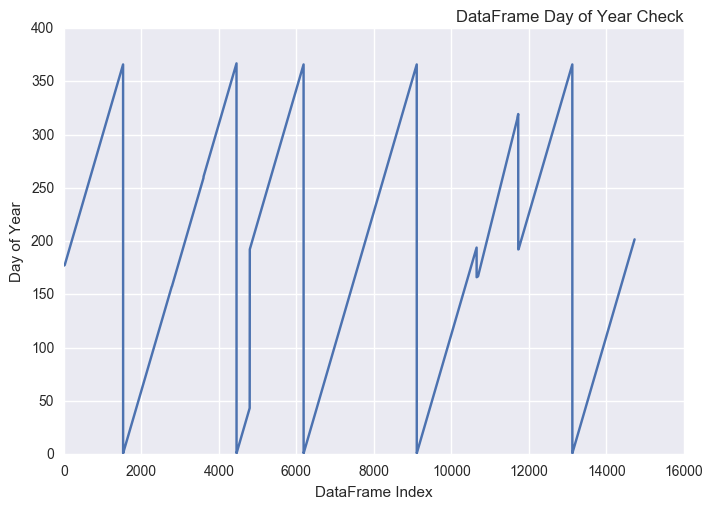

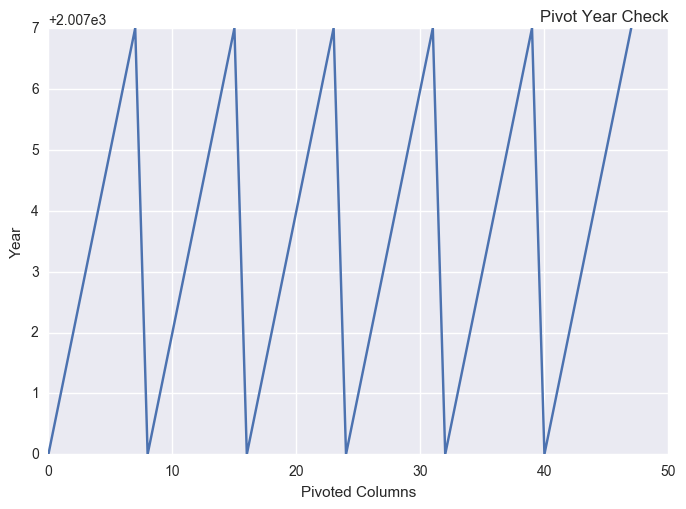

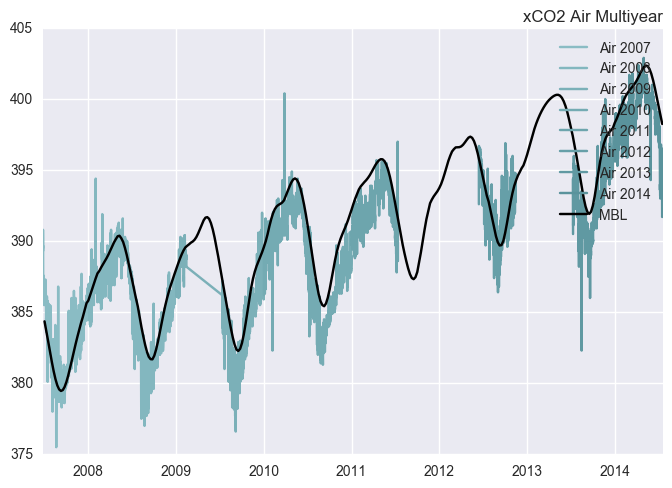

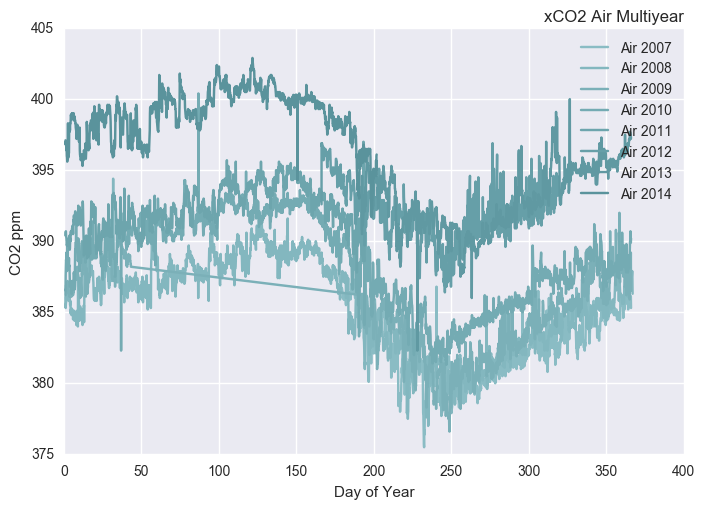

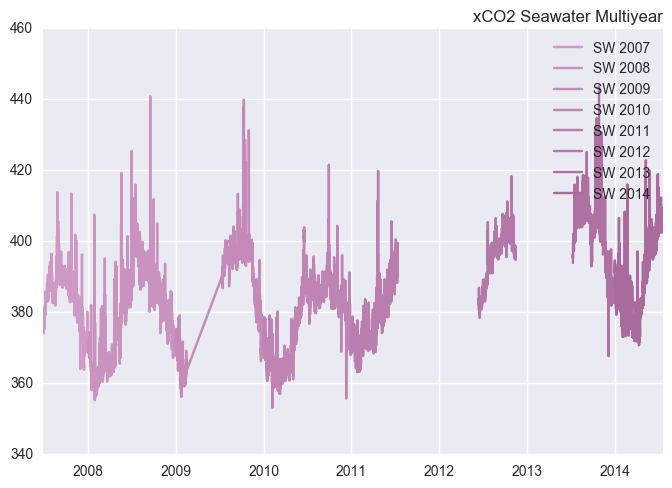

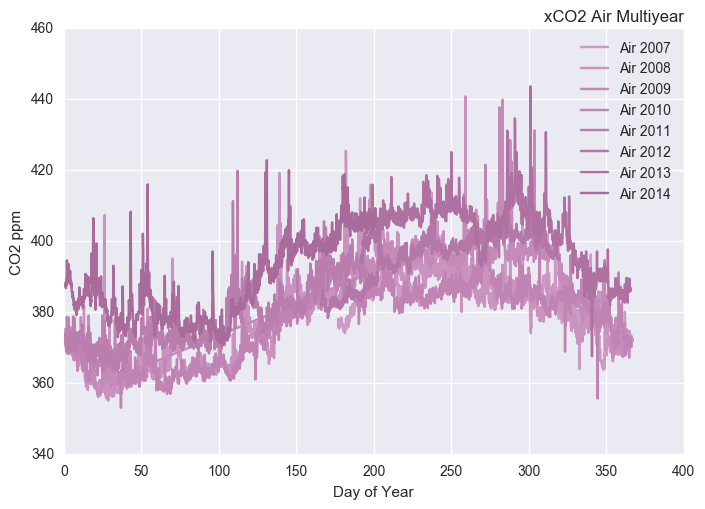

No pH timeseries data to plot
No pH multiyear data to plot


In [42]:
plot_plt.timeseries_multiyear(df, df_mbl)

In [43]:
data_multi = plot_ply.my_data(df)

In [44]:
fig_multi = dict(data=data_multi, layout=layout)
_f = deployment_name_short + '_mapco2_pco2_ph_sstc_multiyear.html'
ply.plot(fig_multi, output_type='file',
         auto_open=True, filename=_f,  show_link=False)

'file://C:\\Users\\dietrich\\data\\mapco2_data\\WHOTS_dp01-07_2007-2014_mapco2_pco2_ph_sstc_multiyear.html'